In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from scikeras.wrappers import KerasRegressor

c:\MyFolder\Projects\University\ml-masters-sem3\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\MyFolder\Projects\University\ml-masters-sem3\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\MyFolder\Projects\University\ml-masters-sem3\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\MyFolder\Projects\University\ml-masters-sem

Лучшие параметры: {'batch_size': 32, 'epochs': 20, 'model__dropout_rate': 0.3, 'model__optimizer': 'adam'}
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


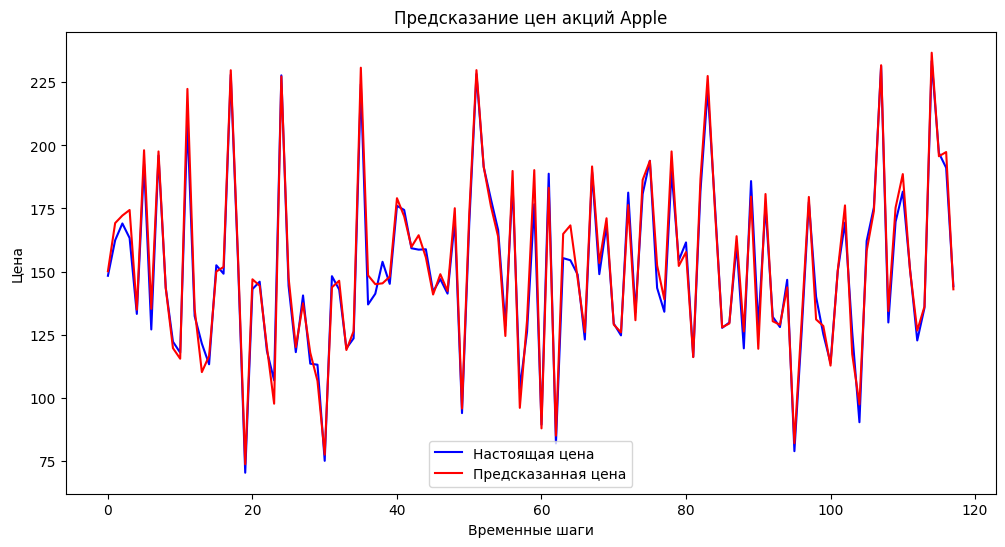

In [4]:
# 1. Загрузка данных
df = pd.read_csv("datasets/AAPL.csv")

# Удаление пропусков
df.dropna(inplace=True)

# Выделяем целевую переменную и признаки
y = df['Adj Close'].values
X = df.drop(['Date', 'Adj Close'], axis=1).values

# 2. Нормализация данных
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# 3. Создание временных окон
def create_dataset(X, y, window_size=60):
    X_out, y_out = [], []
    for i in range(len(X) - window_size):
        X_out.append(X[i:i+window_size])
        y_out.append(y[i+window_size])
    return np.array(X_out), np.array(y_out)

window_size = 60
X_seq, y_seq = create_dataset(X_scaled, y_scaled)

# Разделение на train, validation и test
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 4. Создание модели
def build_model(optimizer='adam', dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_seq.shape[1], X_seq.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

model = KerasRegressor(model=build_model, optimizer='adam', verbose=0)

# Grid Search для настройки гиперпараметров
param_grid = {
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__dropout_rate': [0.2, 0.3]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train, validation_data=(X_valid, y_valid))

# 5. Оценка и графики
print("Лучшие параметры:", grid_result.best_params_)

# Прогноз
best_model = grid_result.best_estimator_.model_
y_pred = best_model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, color='blue', label='Настоящая цена')
plt.plot(y_pred_rescaled, color='red', label='Предсказанная цена')
plt.title('Предсказание цен акций Apple')
plt.xlabel('Временные шаги')
plt.ylabel('Цена')
plt.legend()
plt.show()